Interactive version of the tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pgrigorev/neighbors-maps.git/HEAD?labpath=tutorials%2Fdefect_detection.ipynb)

In [1]:
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
output_notebook()


import sys
sys.path.insert(0, "../")
from neighbor_map import Atoms
from ase.atoms import Atom


def get_cutoff(atoms, n_neightbours, cutoff=10.):
    """
    Function to get the distance of n_th neighbour using matscipy neighbour list.
    """
    from matscipy.neighbours import neighbour_list

    i, d = neighbour_list("id", atoms, cutoff=cutoff)
    first_atom_d = d[i == 0]
    first_atom_d.sort()
    return first_atom_d[n_neightbours]

from helper_functions import interactive_neighbour_map

Loading BokehJS ...

# Construction of a lightweight descriptor of atomic environment

![](img/neighbour_maps.png)

In this tutorial we will implement a [recently proposed](https://arxiv.org/abs/2307.00978) of atomic enviroment called _neighbour maps_.

To understand better how neighbour maps are constructed we will look at four examples of cubic structures:
- Simple Cubic (SC): Po 
- Bulk Centered Cubic (BCC): Fe
- Face Centered Cubic (FCC): Ni
- Diamond: C

[Atomic Simulations Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) has an excellent set of tools for [building things](https://wiki.fysik.dtu.dk/ase/ase/build/build.html). We just need to provide the symbol of the element and it will create a unit cell with the structure and lattice parameter from the internal database. 

In [2]:
from ase.build import bulk

symbols = {"Simple Cubic": "Po", 
           "BCC": "Fe", 
           "FCC": "Ni", 
           "Diamond": "C"}

unit_cells = {}

for structure_type, symbol in symbols.items():
    unit_cells[structure_type] = bulk(symbol, cubic=True)    

We will use [NGLViewer](http://nglviewer.org/ngl/api/index.html) for interactive visualisation of atomic cells. You can use your mouse to:
- Translation: right click + drag

- Rotation: left click + drag

- Z-axis rotation: Ctrl + right click + drag

- Zoom: scroll wheel

- Center view: left click on the desired atom (or its representation)

You can also represent distances by following this procedure:

- Right click on a single atom. You will see a green sphere wrapping it.

- Double right click on another atom. You will see a dashed line between the two atoms, along with the reported distance in Å.

To remove a distance representation, repeat the sequence on the same atoms.

In [3]:
def show_structure(structure):
    from nglview import show_ase, ASEStructure

    # create an empty canvas
    view = show_ase(structure, default_representation=False)
    view.remove_component(view[0])

    # add new component to visualise
    component  = view.add_component(ASEStructure(structure), default_representation=False, name=str(structure.symbols))
    
    # set up the vew as just atomic spheres with unit cell
    scale=0.5
    component.add_spacefill()
    component.update_spacefill(radiusType='covalent',
                            radiusScale=scale)
    component.add_unitcell()

    view.camera = 'orthographic'
    view.parameters = {"clipDist": 0}

    return view


In [4]:
show_structure(unit_cells["Simple Cubic"])

NGLWidget()

In [5]:
show_structure(unit_cells["BCC"])
#show_structure(unit_cells["FCC"])
#show_structure(unit_cells["Diamond"])

NGLWidget()

Lets look on the larger cells that we will use as a mode of bulk structures. To create on we just need to replicate the unit cell N times in each directions. We will use the cells of size 4x4x4 in this tutorial.

In [6]:
bulks = {}

for structure_type, unit_cell in unit_cells.items():
    bulks[structure_type] = Atoms(unit_cell * [4, 4, 4])

The idea behind neighbour maps is to find a simple mapping of an atomic environment into an image that can be used for training a convolutional neural network. From the lecture you might remember that this operation should be invariant with respect to rigid translations, rotations and permutations. One of such operation is a simply taking a distances of a number of neighbours N around an atom and sorting them. This is then repeated for each neihbour giving a mateix of size NxN. Since the closer neighbours are more important final mapping to the image is proportinal to the inverse of the distance 1/D. Taking an example of a BCC structure (Fe) we will now see how this operation can be used to describe an atomic environment around a certain atom and check if it satisfies the desired criteria to be a descriptor.


In [7]:
show_structure(bulks["BCC"])

NGLWidget()

Mapping a 3D atomic environment to a list of sorted distances is equivalent to mapping to a graph where every node is an atom and an edge is a distance. The `interactive_neighbour_map()` function plots this graph on the left and resulting image on the right. Hovering over nods shows the corresponding atom index and highlights all connected edges and clicking on it will show the weights (1/distance) for each edge and highlight the corresponding line on the image. Hovering over the image displays the information for each pixel: central atom index (row number), target atom index, distance and weight. CLicking on a pixel  highlights the row and corresponding node on the graph on the left part. To reset the selection click on the empty area of the plot.
This might sound a but complicated, just start playing with the plot and you will understand it very quick.

In [8]:
Fe = bulks["BCC"]

interactive_neighbour_map(Fe, target_img_size=8, cutoff_factor=1.0)

Lets build a larger image.

In [9]:
interactive_neighbour_map(Fe, target_img_size=32, cutoff_factor=1.0)


And increase cutoff.

In [10]:
interactive_neighbour_map(Fe, target_img_size=32, cutoff_factor=1.2)

To further understand the building process of neighbour maps you can use `show_strucrues()` and `interative_neighbour_maps()` functions to explore Simple Cubic, Face Centered and Diamond structures as well as parameters of builfing the maps: `target_image_size` and `cutoff_factor`.

# Neighbour maps for defects

Now we will look how neighbour maps description of the atomic environment changes when a defect is present. We will look at two cases of a missing atom - vacancy and an extra atom - interstitial.

In [11]:
vacancies = {}
interstitials = {}

for structure_type, bulk in bulks.items():
    vacancy = bulk.copy()
    # delete atom with index 1
    del vacancy[1]
    vacancies[structure_type] = Atoms(vacancy)

    # add an atom
    interstitial = bulk.copy()
    interstitial.extend(Atom(symbol, (2.5, 2.5, 1.5)))
    interstitials[structure_type] = Atoms(interstitial)

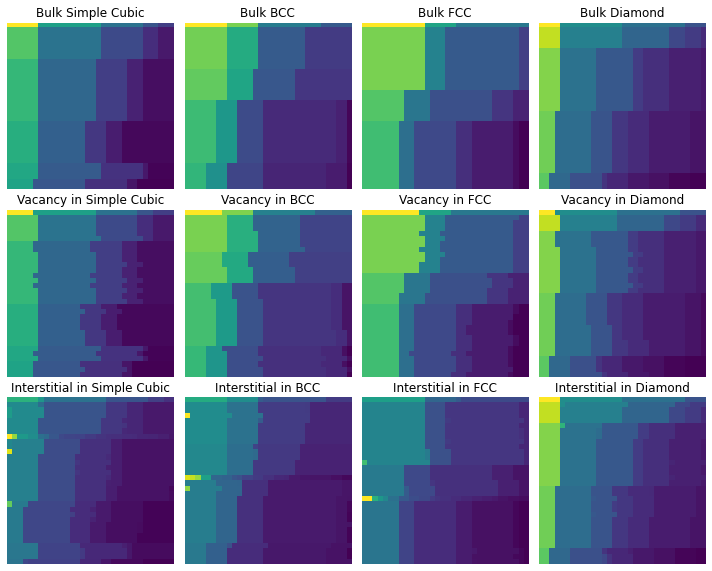

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

for (structure_type, structure), ax in zip(bulks.items(), axes[0]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Bulk " + structure_type)
    ax.axis("off")

for (structure_type, structure), ax in zip(vacancies.items(), axes[1]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Vacancy in " + structure_type)
    ax.axis("off")


for (structure_type, structure), ax in zip(interstitials.items(), axes[2]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Interstitial in " + structure_type)
    ax.axis("off")

    
fig.tight_layout()


It can be seen that the neighbours map reflects very well the change of a local atomic environment due to a presence of a defect. At the same time it keeps the features of the host lattice, i. e. we still can recognise the crystallographic structure by looking at the image. This naturally leads to two main applications of neighbour maps: structure recognition and defect identification.

Lest see what happens if we add a random Gaussian displacement to the structures using [`ase.Atoms.rattle()`](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms.rattle) function to simulate the effect of thermal vibrations.

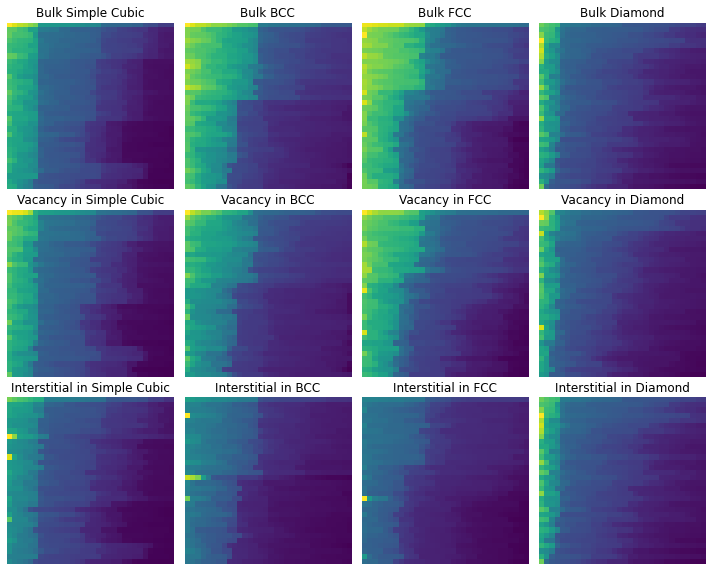

In [13]:
stdev = 0.15 # controls the magnitude of the displacement in Angsroms

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

for (structure_type, structure), ax in zip(bulks.items(), axes[0]):

    structure.rattle(stdev=stdev)
    structure.wrap() # apply periodic boundaries
    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Bulk " + structure_type)
    ax.axis("off")

for (structure_type, structure), ax in zip(vacancies.items(), axes[1]):
    
    structure.rattle(stdev=stdev)
    structure.wrap() # apply periodic boundaries
    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Vacancy in " + structure_type)
    ax.axis("off")


for (structure_type, structure), ax in zip(interstitials.items(), axes[2]):

    structure.rattle(stdev=stdev)
    structure.wrap() # apply periodic boundaries
    
    structure = Atoms(structure)
    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Interstitial in " + structure_type)
    ax.axis("off")

    
fig.tight_layout()

So far we looked to these maps with our naked eyes (and brains), which are in fact a very good tool to look examine an image. However, when we added the Gaussian noise to the positions the it became somewhat more challenging. Can we train a neural network to perform a similar analysis and recognition?

